Préparation de l'environnement de travail

In [446]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

Chargement et exploration des données

In [447]:
data = pd.read_csv("./billets.csv", sep=";")

In [448]:
# Afficher les premières lignes
print(data.head())

# Informations sur le dataset
print(data.info())

# Statistiques descriptives
print(data.describe())

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length    

In [449]:
# Vérifier les valeurs manquantes
print(data.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


is_genuine
True     1000
False     500
Name: count, dtype: int64


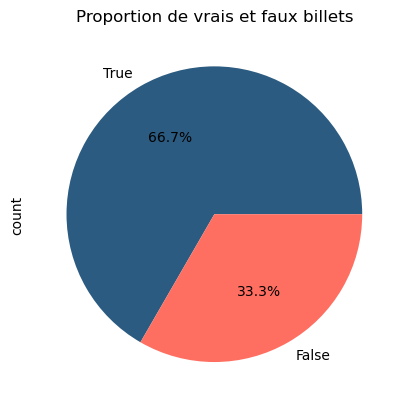

In [450]:
print(data['is_genuine'].value_counts())
data['is_genuine'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#2B5B80', '#FF6F61'])
plt.title("Proportion de vrais et faux billets")
plt.show()

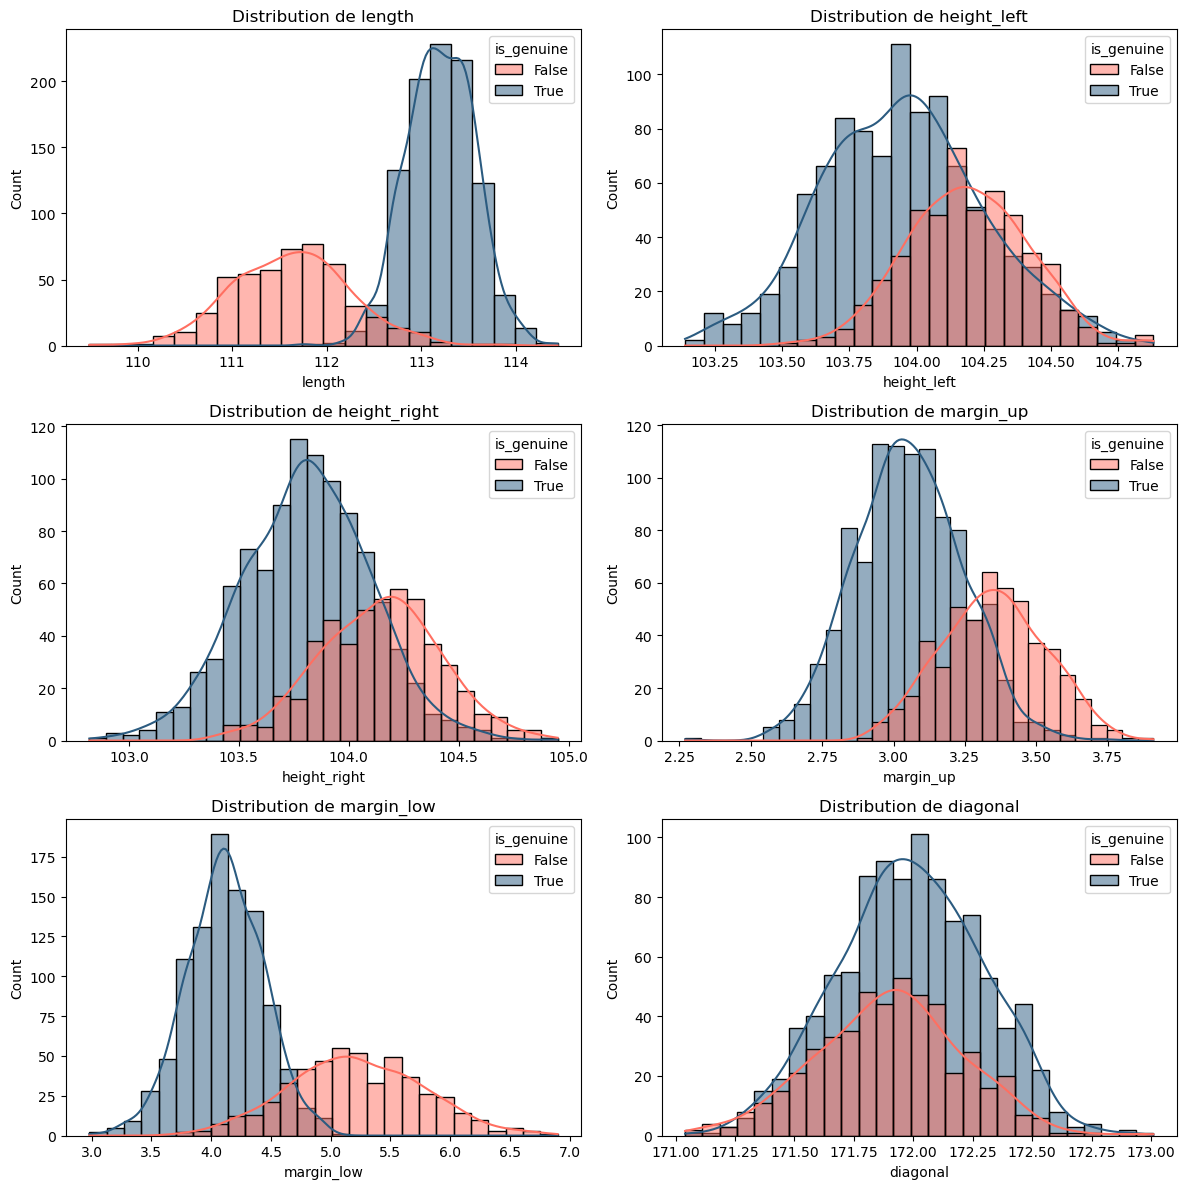

In [451]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12)) 
axes = axes.flatten()  # Aplatit la matrice d'axes pour faciliter l'accès

for i, variable in enumerate(variables):
    sns.histplot(data, x=variable, hue='is_genuine', kde=True, ax=axes[i], palette=['#FF6F61','#2B5B80'])
    axes[i].set_title(f"Distribution de {variable}")

plt.tight_layout()  
plt.show()  

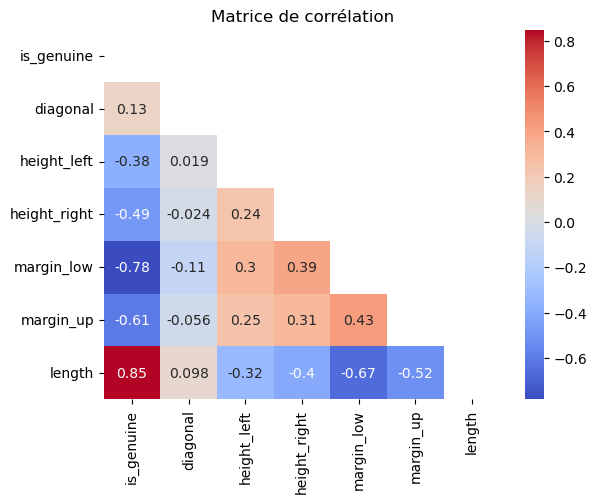

In [452]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

Prétraitement des données

In [453]:
# Regression linéaire pour les données manquantes

In [454]:
# Séparer les données complètes et les données vides
df_complete = data.dropna(subset=['margin_low'])
df_missing = data[data['margin_low'].isnull()]

In [455]:
# Définir les variables X (indépendantes) et y (dépendante)
X_complete = df_complete[['diagonal', 'height_left','height_right','margin_up','length']]  # Variables indépendantes
y_complete = df_complete['margin_low']  # Variable dépendante

regression = LinearRegression()
regression.fit(X_complete, y_complete)

# Prédire les valeurs manquantes
X_missing = df_missing[['diagonal', 'height_left','height_right','margin_up','length']]
predicted_margin_low = regression.predict(X_missing)

In [456]:
data_clean = data.copy()
data_clean.loc[data_clean['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

Verifications des données

In [457]:
data_clean['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Division des données en ensembles d'entraînement et de test

In [458]:
# Définir les caractéristiques
X = data_clean.drop('is_genuine', axis=1)

# Définir la cible
y = data_clean['is_genuine']

In [459]:
display(X.head())
display(y.head())

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [461]:
print("Dimensions de X :", X.shape)
print("Dimensions de X_train :", X_train.shape)
print("Dimensions de X_test :", X_test.shape)

Dimensions de X : (1500, 6)
Dimensions de X_train : (1200, 6)
Dimensions de X_test : (300, 6)


In [462]:
print("Répartition des classes dans y_train :")
print(y_train.value_counts())

print("Répartition des classes dans y_test :")
print(y_test.value_counts())


Répartition des classes dans y_train :
is_genuine
True     800
False    400
Name: count, dtype: int64
Répartition des classes dans y_test :
is_genuine
True     200
False    100
Name: count, dtype: int64


Verifier le modèle de regression linéaire

In [463]:
# Entraîner le modèle
regression.fit(X_train, y_train)
# Faire des prédictions sur l'ensemble de test
y_pred = regression.predict(X_test)

In [464]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
# Calcul du coefficient de détermination (R²)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient de détermination (R²): {r2}")

Mean Squared Error (MSE): 0.03635070510820613
Coefficient de détermination (R²): 0.8364218270130723


Normalisation des données

standardisation aux données pour KNN

In [465]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [466]:
print("Moyenne des caractéristiques après standardisation :")
print(X_train_scaled.mean(axis=0))

print("\nÉcart-type des caractéristiques après standardisation :")
print(X_train_scaled.std(axis=0))

Moyenne des caractéristiques après standardisation :
[ 3.20232729e-14 -1.70086167e-15  2.18077408e-14 -2.36847579e-16
 -2.28705943e-16  2.31074419e-15]

Écart-type des caractéristiques après standardisation :
[1. 1. 1. 1. 1. 1.]


Mise en place des modèles de machine learning

Régression logistique

In [467]:
# Initialiser le modèle et l'entrainer
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Lancer la prédiction
y_pred_logreg = logreg.predict(X_test_scaled)

In [468]:
#Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Exactitude de la régression logistique :", accuracy)

Exactitude de la régression logistique : 0.9833333333333333


Exactitude : Représente le pourcentage de prédictions correctes sur l'ensemble de test. Une valeur proche de 1 (ou 100%) indique une bonne performance globale.

In [469]:
#Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_logreg)
print("Matrice de confusion :\n", cm)

Matrice de confusion :
 [[ 95   5]
 [  0 200]]


In [470]:
#rapport de classification
cr = classification_report(y_test, y_pred_logreg)
print("Rapport de classification :\n", cr)

Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.95      0.97       100
        True       0.98      1.00      0.99       200

    accuracy                           0.98       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



Kmeans


In [471]:
kmeans = KMeans(n_clusters=2, random_state=7)

In [472]:
#Entraîner le modèle sur l'ensemble d'entraînement
kmeans.fit(X_train_scaled)
#Effectuer des prédictions sur l'ensemble de test
y_pred_kmeans = kmeans.predict(X_test_scaled)

In [473]:
print(y_train.dtype)

bool


In [475]:
from scipy.stats import mode
# Mapper les clusters aux labels majoritaires
cluster_labels = {cluster: y_train.iloc[np.where(train_clusters == cluster)].mode()[0]
                  for cluster in np.unique(train_clusters)}

# Mapper les clusters prédits aux labels réels
y_pred_kmeans_mapped = [cluster_labels[cluster] for cluster in y_pred_kmeans]

In [476]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_kmeans_mapped)
print("Exactitude du K-means :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_kmeans_mapped)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_kmeans_mapped)
print("Rapport de classification :\n", cr)

Exactitude du K-means : 0.9733333333333334
Matrice de confusion :
 [[ 95   5]
 [  3 197]]
Rapport de classification :
               precision    recall  f1-score   support

       False       0.97      0.95      0.96       100
        True       0.98      0.98      0.98       200

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



KNN (K-Nearest Neighbors)

In [477]:
knn = KNeighborsClassifier(n_neighbors=5)

In [478]:
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [479]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_knn)
print("Exactitude du KNN :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_knn)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_knn)
print("Rapport de classification :\n", cr)


Exactitude du KNN : 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



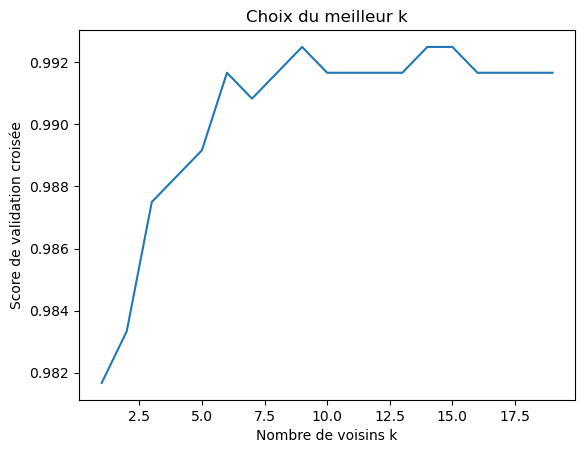

In [480]:
from sklearn.model_selection import cross_val_score

# Tester différents k
k_values = range(1, 20)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    scores.append(knn_scores.mean())

# Tracer les scores
plt.plot(k_values, scores)
plt.xlabel('Nombre de voisins k')
plt.ylabel('Score de validation croisée')
plt.title('Choix du meilleur k')
plt.show()

Random Forest

In [481]:
rf = RandomForestClassifier(n_estimators=100, random_state=7)

In [482]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [483]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_rf)
print("Exactitude du Random Forest :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_rf)
print("Rapport de classification :\n", cr)


Exactitude du Random Forest : 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



  Caractéristique  Importance
5          length    0.524257
3      margin_low    0.265424
4       margin_up    0.106928
2    height_right    0.060756
1     height_left    0.032938
0        diagonal    0.009696


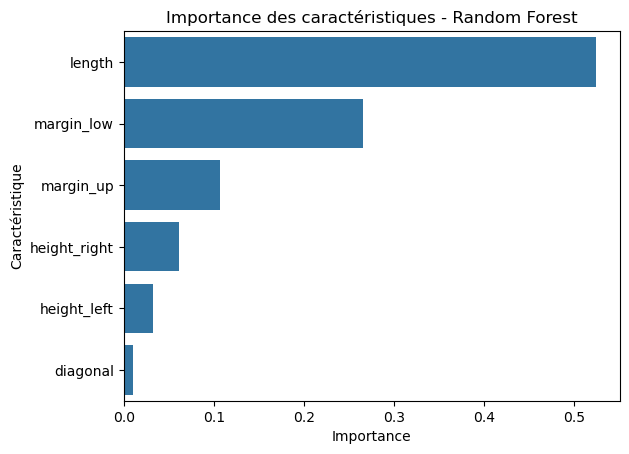

In [484]:
# Obtenir l'importance des caractéristiques
importances = rf.feature_importances_
feature_names = X_train.columns

# Créer un dataframe pour visualiser
feature_importance_df = pd.DataFrame({'Caractéristique': feature_names, 'Importance': importances})

# Trier les caractéristiques par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Afficher les importances
print(feature_importance_df)

# Visualiser
sns.barplot(x='Importance', y='Caractéristique', data=feature_importance_df)
plt.title("Importance des caractéristiques - Random Forest")
plt.show()


Régression linéaire

In [485]:
lin_reg = LinearRegression()


In [486]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)
threshold = 0.5
y_pred_lin_class = np.where(y_pred_lin >= threshold, 1, 0)


In [487]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_lin_class)
print("Exactitude de la régression linéaire :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_lin_class)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_lin_class)
print("Rapport de classification :\n", cr)


Exactitude de la régression linéaire : 0.9833333333333333
Matrice de confusion :
 [[ 95   5]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.95      0.97       100
        True       0.98      1.00      0.99       200

    accuracy                           0.98       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



Rapport

In [488]:
# Régression logistique
print("Régression Logistique")
print(classification_report(y_test, y_pred_logreg))

# KNN
print("KNN")
print(classification_report(y_test, y_pred_knn))

# Random Forest
print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Régression Logistique
              precision    recall  f1-score   support

       False       1.00      0.95      0.97       100
        True       0.98      1.00      0.99       200

    accuracy                           0.98       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300

KNN
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

Random Forest
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99 